## Advanced Lane Finding Project

The goals / steps of this project are the following:

* [x] Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* [x] Apply a distortion correction to raw images.
* [x] Use color transforms, gradients, etc., to create a thresholded binary image.
* [x] Apply a perspective transform to rectify binary image ("birds-eye view").
* [x] Detect lane pixels and fit to find the lane boundary.
* [x] Determine the curvature of the lane and vehicle position with respect to center.
* [x] Warp the detected lane boundaries back onto the original image.
* [x] Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera Calibration

In [1]:
from IPython.display import clear_output
import time

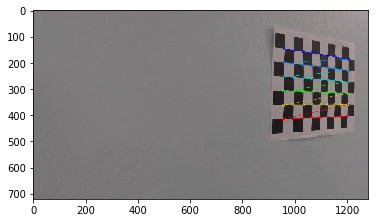

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for ii, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        if ii == 0:
            plt.figure()
            plt.imshow(img)

In [3]:
# Let's grab the camera matrix and coefficients
h, w = gray.shape[0:2]
ret, camera_mat, distort_coeff, _, _ = cv2.calibrateCamera(objpoints, imgpoints, (w, h), None, None)

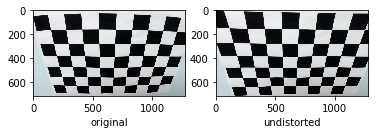

In [4]:
# And a quick test to see if the numbers are sane
plt.subplot(1, 2, 1)
im = cv2.imread(images[13])
plt.imshow(im)
plt.xlabel('original')
plt.subplot(1, 2, 2)
imd = cv2.undistort(im, camera_mat, distort_coeff)
plt.imshow(imd)
plt.xlabel('undistorted')

# ... they appear to be sane

In [5]:
# These are empirically decided upon constants we use later
pixels_per_meter = 750/3.7
car_center_in_pixels = 622.5

In [6]:
def fit_line_and_find_curvature(im, left_im, old_l):
    """
    This function takes in a binary mask showing either the left or right lane line
    as well as a value for past coefficients (which may be None). It then tries to fit
    a new line or keeps an old one upon catastrophic failure
    """
    coeffs = np.polyfit(np.where(left_im>0)[0], np.where(left_im>0)[1], 2)
    if not isinstance(old_l, np.ndarray):
        old_l = coeffs
    
    yy = np.array(range(im.shape[0]))
    xx = np.polyval(coeffs, yy)
    xx_old = np.polyval(old_l, yy)
    mmm = np.mean((xx-xx_old)**2)

    # This is my test to see if something has gone wrong, it is essentially just looking
    # to see there is a large enough (empirically discovered) MSE between the current and
    # last fit.
    if mmm > 1000: # may need to be different for R and L
        coeffs = old_l
        xx = np.polyval(coeffs, yy)
    else:
        old_l = coeffs
    deriv = np.diff(xx)/(yy[1]-yy[0])
    deriv2 = np.diff(deriv)/(yy[1]-yy[0])
    curv_l = 1/(np.abs(deriv2[-1])/(1+deriv[-1]**2)**(3/2.))/pixels_per_meter

    xxyy1 = np.array([np.vstack((xx, yy)).T]).astype('int32')
    
    return curv_l, xxyy1, old_l

def process_image(im, old_l, old_r):
    # First we undistort...
    undistorted_image = cv2.undistort(im, camera_mat, distort_coeff)
    
    # Then I do the bird's eye transform
    h, w = undistorted_image.shape[0:2]
    mid = h/2 + 100
    side = 565
    bottom = 100
    src = np.float32([(bottom,h), (side, mid), (w-side+28, mid), (w-bottom, h)])
    dst = np.float32([(bottom,h*2), (bottom, 0), (w-bottom, 0), (w-bottom*3, h*2)])
    warp_mat = cv2.getPerspectiveTransform(src, dst)
    hls_full = cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2HLS)
    
    '''
    cv2.polylines(undistorted_image, np.array([src.astype('int32')]), False, (0, 0, 255), 5)
    plt.imshow(undistorted_image[:,:,::-1])
    '''
    
    transformed = cv2.warpPerspective(hls_full, warp_mat, (w+20, h*2))
    '''
    plt.figure()
    plt.imshow(cv2.cvtColor(transformed, cv2.COLOR_HLS2RGB))
    '''
    
    hls = transformed

    # and normalize the S channel
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    s_channel = (s_channel.astype('float64')/s_channel.max()*255).astype('uint8')

    # I threshold the s and l channels
    threshs = cv2.threshold(s_channel, 90, 255, cv2.THRESH_BINARY)[1]
    threshl = cv2.threshold(l_channel, 200, 255, cv2.THRESH_BINARY)[1]
    thresh_combined = cv2.add(threshs, threshl)
    
    '''
    plt.subplot(1, 3, 1)
    plt.imshow(threshs, cmap='gray')
    plt.xlabel('S Channel')
    plt.subplot(1, 3, 2)
    plt.imshow(threshl, cmap='gray')
    plt.xlabel('L Channel')
    plt.subplot(1, 3, 3)
    plt.imshow(thresh_combined, cmap='gray')
    plt.xlabel('Combined')
    '''
    
    im = np.dstack((thresh_combined,)*3)
    left_im = np.zeros_like(thresh_combined)
    right_im = np.zeros_like(thresh_combined)
    
    # I then extract let and right lane lines as binary masks
    for ii in range(5):
        y1 = ii*288
        y2 = (ii+1)*288
        hist = np.sum(thresh_combined[y1:y2,:], axis=0)
        left_point = np.argmax(hist[0:500])
        right_point = 500 + np.argmax(hist[500:])
        sz = 100
        cv2.rectangle(im, (left_point-sz, y1), (left_point+sz, y2), (255, 0, 0), 20)
        left_im[y1:y2, (left_point-sz):(left_point+sz)] = thresh_combined[y1:y2, (left_point-sz):(left_point+sz)]
        if right_point > 650 and im.shape[1]-right_point-sz > 20:
            cv2.rectangle(im, (right_point-sz, y1), (right_point+sz, y2), (0, 255, 0), 20)
            right_im[y1:y2, (right_point-sz):(right_point+sz)] = thresh_combined[y1:y2, (right_point-sz):(right_point+sz)]

    #plt.imshow(im)
            
    # and fit a line and detect curvature for them
    curv_l, xxyy1, old_l = fit_line_and_find_curvature(im, left_im, old_l)
    curv_r, xxyy2, old_r = fit_line_and_find_curvature(im, right_im, old_r)
    
    # I then create the final image
    lane_im = np.zeros_like(im).astype('uint8')    
    final_poly_pts = np.array([np.vstack((xxyy1[0], xxyy2[:, ::-1, :][0]))])
    cv2.fillPoly(lane_im, final_poly_pts, (0,100, 0))
    inverted = cv2.warpPerspective(lane_im, np.linalg.inv(warp_mat), (frame.shape[1], frame.shape[0]))
    
    added = cv2.add(undistorted_image, inverted)
    
    center = (xxyy2[0, -1, 0] - xxyy1[0, -1, 0])/2 + xxyy1[0, -1, 0]
    
    center_deviation = (car_center_in_pixels-center)/pixels_per_meter
    
    return curv_l, curv_r, center_deviation, xxyy1, xxyy2, added, old_l, old_r

100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


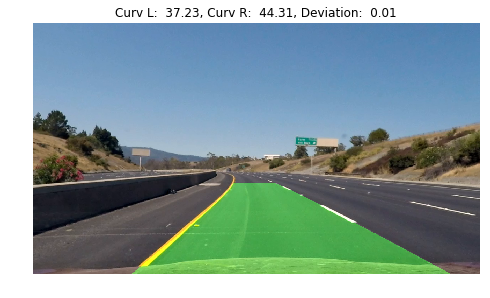

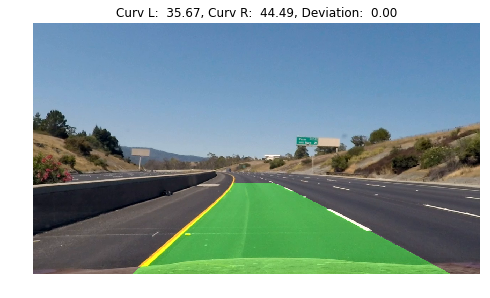

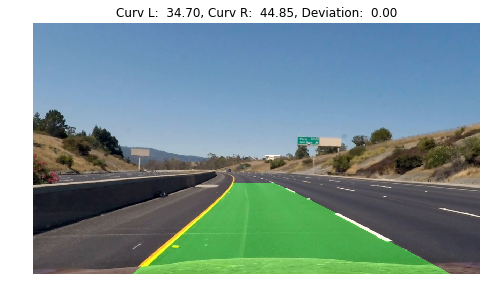

In [7]:
frames = glob.glob('project_video/*')[0:3]
from tqdm import tqdm
old_l = None
old_r = None
for ii, frame_name in tqdm(enumerate(frames), total=len(frames)):
    frame = cv2.imread('project_video/frame{}.png'.format(str(ii+1).zfill(4)))
    curv_l, curv_r, center_deviation, xxyy1, xxyy2, added, old_l, old_r = process_image(frame, old_l, old_r)
    clear_output(wait=True)
    plt.figure(figsize=(8,5))
    plt.imshow(added[:,:,::-1])
    plt.title('Curv L:  {0:.2f}, Curv R:  {1:.2f}, Deviation:  {2:.2f}'.format(curv_l, curv_r, center_deviation))
    plt.axis('off')
    #plt.show()
    plt.savefig('project_out/{}.png'.format(str(ii).zfill(4)))
    time.sleep(0.001)

## Appendix: Old experimental code

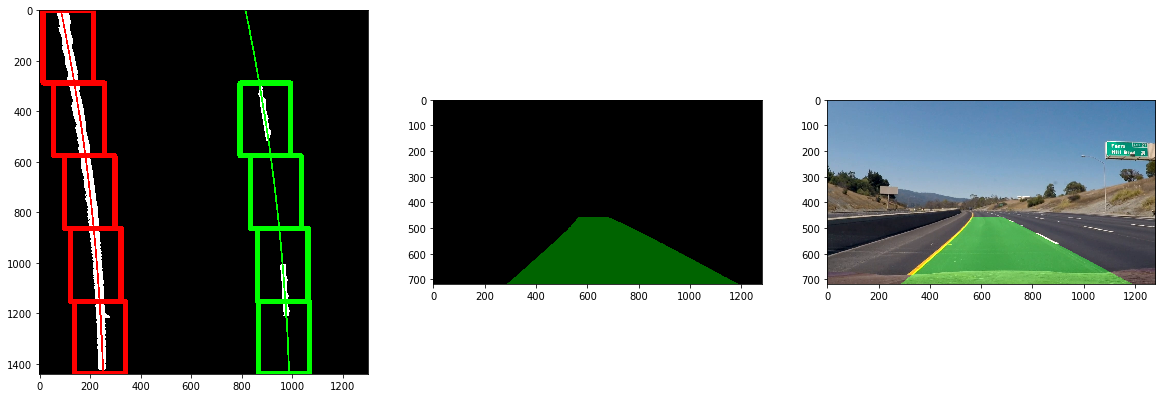

 51%|█████     | 51/100 [01:03<01:04,  1.31s/it]

43.199044887
40.0327253471


In [131]:
frames = glob.glob('project_video/*')[0:100]
from tqdm import tqdm
old_l = None
old_r = None
mse = []
for ii, frame_name in tqdm(enumerate(frames), total=len(frames)):
    try:
        frame = cv2.imread('project_video/frame{}.png'.format(str(ii+1).zfill(4)))
        resp = process_image(frame, old_l, old_r)
        

        cv2.polylines(resp[0], xxyy1, False, (255, 0, 0), 5)

        cv2.polylines(resp[0], xxyy2, False, (0, 255, 0), 5)
        #inverted = cv2.warpPerspective(resp[0], np.linalg.inv(resp[-1]), (frame.shape[1], frame.shape[0]))
        lane_im = np.zeros_like(resp[0]).astype('uint8')
        
        final_poly_pts = np.array([np.vstack((xxyy1[0], xxyy2[:, ::-1, :][0]))])
        cv2.fillPoly(lane_im, final_poly_pts, (0,100, 0))
        inverted = cv2.warpPerspective(lane_im, np.linalg.inv(resp[-1]), (frame.shape[1], frame.shape[0]))
        added = cv2.add(frame, inverted)
        #added = lane_im
        clear_output(wait=True)
        
        plt.figure(figsize=(20,20))

        plt.subplot(1, 3, 1)
        plt.imshow(resp[0])
        
        plt.subplot(1, 3, 2)
        plt.imshow(inverted)
        #plt.plot(mse)
        #plt.plot(xx,yy,'r')
        
        plt.subplot(1, 3, 3)
        plt.imshow(added[:,:,::-1])
        
        plt.plot([pt[0] for pt in resp[2]], [pt[1] for pt in resp[2]])
        plt.show()
        time.sleep(0.01)
        print(curv_l)
        print(curv_r)
        cv2.imwrite('/tmp/{}.png'.format(str(ii).zfill(4)), added)
    except KeyboardInterrupt as e:
        break
    except Exception as e:
        print(str(e))